<a href="https://colab.research.google.com/github/Shan-Lee2k/Image-Processing-and-Computer-Vision/blob/main/Panorama_Image_Stictching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBRARY AND LOAD IMAGE

In [179]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
from google.colab import drive

In [180]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
def plot_image(image,tilte = "Original",figsize = (12,7) ):
  plt.figure(figsize = figsize)
  plt.imshow(image)
  plt.axis("off")
  plt.title(tilte)
  plt.show()


In [182]:
h1 = cv2.imread("/content/drive/MyDrive/OpenCV/H1.jpg")
h1 = cv2.resize(h1,None, fx = 0.25, fy=0.25)
h1 = cv2.cvtColor(h1, cv2.COLOR_BGR2RGB)
h1_gray =  cv2.cvtColor(h1, cv2.COLOR_RGB2GRAY)


h2 =  cv2.imread("/content/drive/MyDrive/OpenCV/H2.jpg")
h2 = cv2.resize(h2,None, fx = 0.25, fy=0.25)
h2 = cv2.cvtColor(h2, cv2.COLOR_BGR2RGB)
h2_gray =  cv2.cvtColor(h2, cv2.COLOR_RGB2GRAY)


h3 =  cv2.imread("/content/drive/MyDrive/OpenCV/H3.jpg")
h3 = cv2.resize(h3,None, fx = 0.25, fy=0.25)
h3 = cv2.cvtColor(h3, cv2.COLOR_BGR2RGB)
h3_gray =  cv2.cvtColor(h3, cv2.COLOR_RGB2GRAY)


# FEATURE EXTRACTION

<Figure size 1500x1000 with 0 Axes>

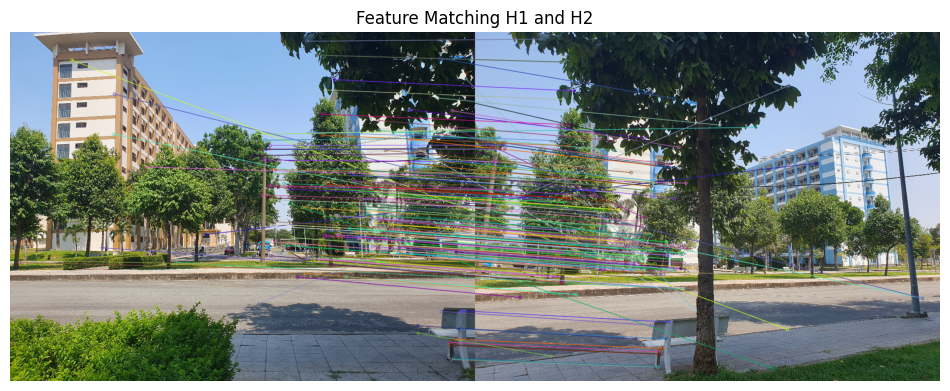

In [183]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(h1_gray, None)
kp2, des2 = sift.detectAndCompute(h2_gray, None)

## Match keypoint
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

## Bruce Force KNN trả về list k ứng viên cho mỗi keypoint.
rawMatches = bf.knnMatch(des1, des2, 2)
matches = []
ratio = 0.75

for m,n in rawMatches:
    # giữ lại các cặp keypoint sao cho với kp1, khoảng cách giữa kp1 với ứng viên 1 nhỏ hơn nhiều so với khoảng cách giữa kp1 và ứng viên 2
    if m.distance < n.distance * 0.75:
        matches.append(m)

# do có cả nghìn match keypoint, ta chỉ lấy tầm 100 -> 200 cặp tốt nhất để tốc độ xử lí nhanh hơn
matches = sorted(matches, key=lambda x: x.distance, reverse=True)
matches = matches[:200]

H1_H2 = cv2.drawMatches(h1, kp1, h2, kp2, matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15,10))
plot_image(H1_H2, "Feature Matching H1 and H2")


4647


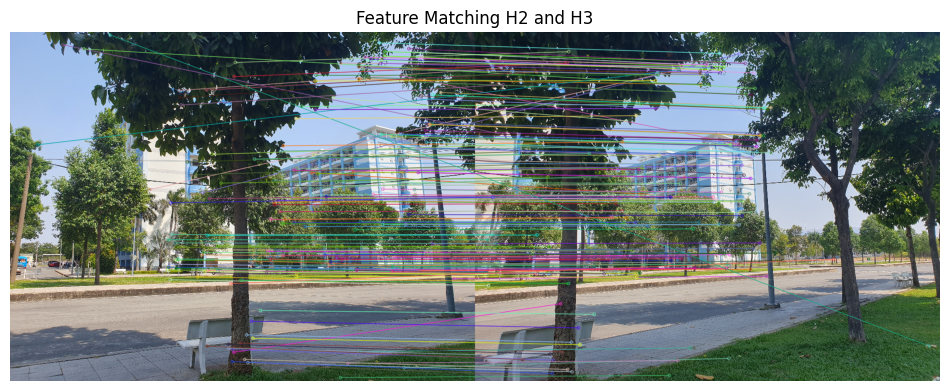

In [184]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(h2_gray, None)
kp2, des2 = sift.detectAndCompute(h3_gray, None)
print(len(kp1))
## Match keypoint
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

## Bruce Force KNN trả về list k ứng viên cho mỗi keypoint.
rawMatches = bf.knnMatch(des1, des2, 2)
matches = []
ratio = 0.75

for m,n in rawMatches:
    if m.distance < n.distance * 0.75:
        matches.append(m)

# do có cả nghìn match keypoint, ta chỉ lấy tầm 100 -> 200 cặp tốt nhất để tốc độ xử lí nhanh hơn
matches = sorted(matches, key=lambda x: x.distance, reverse=True)
matches = matches[:200]

H2_H3 = cv2.drawMatches(h2, kp1, h3, kp2, matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plot_image(H2_H3, "Feature Matching H2 and H3")

# IMPLEMENT PANORAMA CLASS AND STICTCHING IMAGE

In [185]:
class Panaroma:
    def image_stitch(self, images, lowe_ratio=0.75, max_Threshold=4.0, match_status=False):
        # detect the features and keypoints from SIFT
        (imageB, imageA) = images
        (key_points_A, features_of_A) = self.detect_feature_and_keypoints(imageA)
        (key_points_B, features_of_B) = self.detect_feature_and_keypoints(imageB)

        # get the valid matched points
        Values = self.match_keypoints(key_points_A, key_points_B, features_of_A, features_of_B, lowe_ratio, max_Threshold)
        if Values is None:
            return None

        # get wrap perspective of image using computed homography
        (matches, Homography, status) = Values
        result_image = self.get_warp_perspective(imageA, imageB, Homography)
        result_image[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # check to see if the keypoint matches should be visualized
        if match_status:
            vis = self.draw_matches(imageA, imageB, key_points_A, key_points_B, matches, status)
            return result_image, vis

        return result_image


    def get_warp_perspective(self, imageA, imageB, Homography):
        val = imageA.shape[1] + imageB.shape[1]
        result_image = cv2.warpPerspective(imageA, Homography, (val, imageA.shape[0]))
        return result_image


    def detect_feature_and_keypoints(self, image):
        # detect and extract features from the image
        descriptors = cv2.SIFT_create()
        (keypoints, features) = descriptors.detectAndCompute(image, None)
        keypoints = np.float32([i.pt for i in keypoints])
        return keypoints, features


    def get_all_possible_matches(self, featuresA, featuresB):
        # compute the all matches using Euclidean distance. Opencv provide DescriptorMatcher_create() function for that
        match_instance = cv2.DescriptorMatcher_create("BruteForce")
        All_Matches = match_instance.knnMatch(featuresA, featuresB, 2)
        return All_Matches


    def get_all_valid_matches(self, AllMatches, lowe_ratio):
        # to get all valid matches according to lowe concept..
        valid_matches = []
        for val in AllMatches:
            if len(val) == 2 and val[0].distance < val[1].distance * lowe_ratio:
                valid_matches.append((val[0].trainIdx, val[0].queryIdx))
        return valid_matches


    def compute_homography(self, pointsA, pointsB, max_Threshold):
        return cv2.findHomography(pointsA, pointsB, cv2.RANSAC, max_Threshold)


    def match_keypoints(self, KeypointsA, KeypointsB, featuresA, featuresB, lowe_ratio, max_Threshold):
        all_matches = self.get_all_possible_matches(featuresA, featuresB)
        valid_matches = self.get_all_valid_matches(all_matches, lowe_ratio)

        if len(valid_matches) <= 4:
            return None

        # construct the two sets of points
        points_A = np.float32([KeypointsA[i] for (_, i) in valid_matches])
        points_B = np.float32([KeypointsB[i] for (i, _) in valid_matches])
        (homograpgy, status) = self.compute_homography(points_A, points_B, max_Threshold)
        return valid_matches, homograpgy, status


    def get_image_dimension(self, image):
        return image.shape[:2]


    def get_points(self, imageA, imageB):
        (hA, wA) = self.get_image_dimension(imageA)
        (hB, wB) = self.get_image_dimension(imageB)
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB
        return vis


    def draw_matches(self, imageA, imageB, KeypointsA, KeypointsB, matches, status):
        (hA, wA) = self.get_image_dimension(imageA)
        vis = self.get_points(imageA, imageB)

        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            if s == 1:
                ptA = (int(KeypointsA[queryIdx][0]), int(KeypointsA[queryIdx][1]))
                ptB = (int(KeypointsB[trainIdx][0]) + wA, int(KeypointsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
        return vis

In [186]:
panorama = Panaroma()
h1_h2, _ = panorama.image_stitch([h1,h2], match_status= True)
h2_h3, _ = panorama.image_stitch([h2,h3], match_status= True)

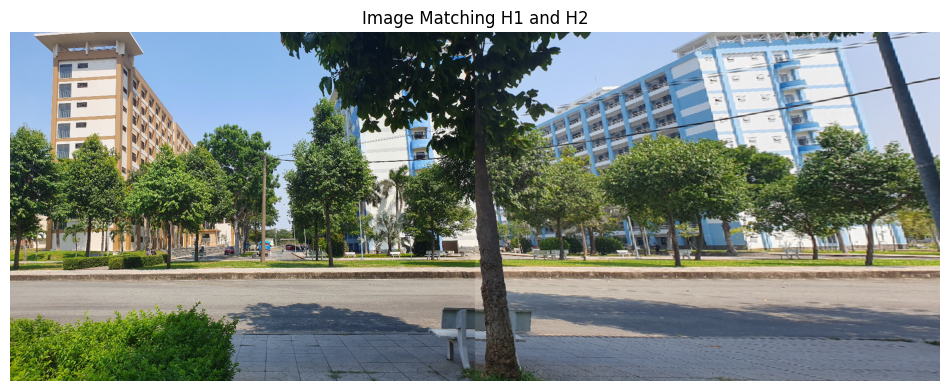

In [187]:
plot_image(h1_h2, "Image Matching H1 and H2")

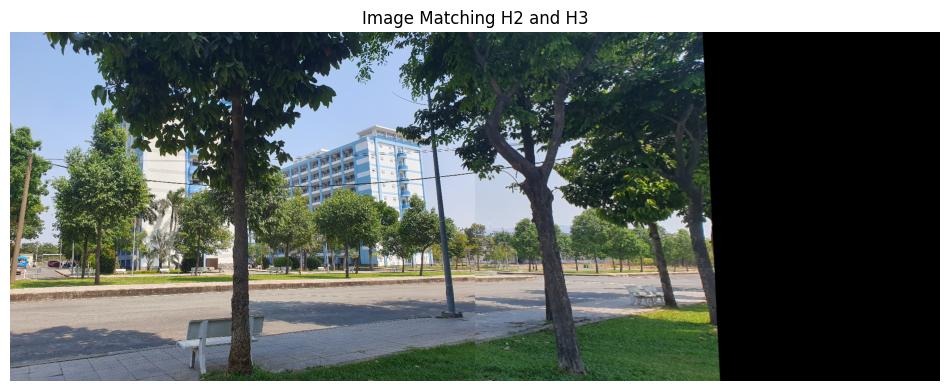

In [188]:
plot_image(h2_h3, "Image Matching H2 and H3")

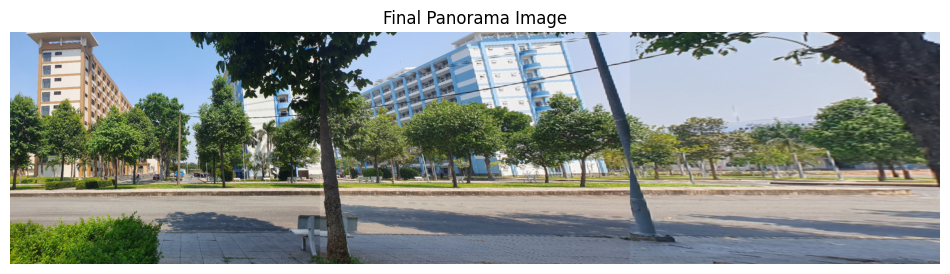

In [189]:
final, _ = panorama.image_stitch([h1_h2,h3], match_status= True)
final  = cv2.resize(final,None, fx =2,  fy=2)
plot_image(final, "Final Panorama Image")